In [1]:
import os
import json
import random
import argparse
import itertools
import math
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from tqdm import tqdm

from torchvision.datasets import MNIST

from models import (
    RQVAE
)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def get_transform():
    data_transforms = []
    data_transforms.append(transforms.ToTensor())
    data_transforms.append(transforms.Normalize((0.1307,), (0.3081,)))
    return transforms.Compose(data_transforms)

def run(device):
    train_loader = DataLoader(MNIST(root='../data', download=True, transform=get_transform()), batch_size=64)
    test_loader = DataLoader(MNIST(root='../data', download=True, transform=get_transform(), train=False), batch_size=16, shuffle=True)
    
    rqvae = RQVAE(
        in_channels=1,
        embedding_dim=28,
        num_embeddings=128,
        hidden_dims=[16, 64, 128]
    ).to(device)
    
    # optimizer
    optimizer = optim.Adam(rqvae.parameters(), lr=1e-3)
    
    for epoch in range(5):
        train(device, epoch, rqvae, optimizer, [train_loader, test_loader])

def train(device, epoch, model, optimizer, loaders):
    train_loader, test_loader = loaders
    epoch_loss = 0

    for data, _ in tqdm(train_loader):
        data = data.to(device).float()

        recon, _, commit_loss = model(data)
        loss = model.loss_function(recon, data, commit_loss)['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss / len(train_loader)
    
    with torch.no_grad():
        for data, _ in test_loader:  
            data = data.to(device).float()
            reconstruct_data = model.reconstruct(data)
            
            new_x = torch.cat([data, reconstruct_data.detach()], dim=0)
            grid_pics = make_grid(new_x.to('cpu'), 8)
            plt.imshow(grid_pics.permute(1,2,0))
            break
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f}\n"
    )

100%|██████████| 938/938 [01:55<00:00,  8.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 - loss : 0.4907



100%|██████████| 938/938 [02:00<00:00,  7.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 - loss : 0.3868



100%|██████████| 938/938 [01:59<00:00,  7.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 - loss : 0.3734



100%|██████████| 938/938 [01:55<00:00,  8.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 - loss : 0.3678



100%|██████████| 938/938 [01:58<00:00,  7.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 - loss : 0.3642



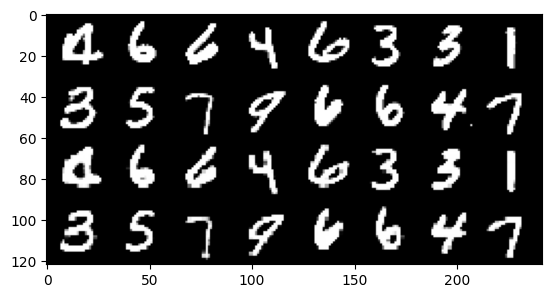

In [2]:
seed_everything(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

run(device)